In [10]:
from skimage.filters import threshold_local
from skimage import morphology
import cv2
import matplotlib.pyplot as plt
import os

In [11]:
class Character_segment:
    def __init__(self,platePath,dst):
        self.platePath = platePath
        self.dst = dst
        self.plateImg = None
        self.height = 0
        self.extract()

    def readImage(self):
        self.plateImg = cv2.imread(self.platePath)
        self.height = self.plateImg.shape[0]

    def processing(self):
        # First we read input image, later convert into HSV
        # Split to take V channel and apply local binary threshold on it
        # Use canny to find boundaries and dilate to thicken them
        self.readImage()
        raw_img = self.plateImg
        
        V = cv2.split(cv2.cvtColor(raw_img, cv2.COLOR_BGR2HSV))[2]
        
        T = threshold_local(V, block_size=65, offset=15, method='gaussian')
        thresh = (V > T).astype("uint8")*255
        thresh = cv2.bitwise_not(thresh)
        
        self.plateImg = thresh

        opening = morphology.area_opening(thresh, area_threshold=256)
        closing = morphology.area_closing(opening, area_threshold=512)

        canny = cv2.Canny(closing, 0, 255, 1)

        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        dilate = cv2.dilate(canny, kernel, iterations=1)
        return dilate

    def extract(self):
        img = self.processing()
        contours = cv2.findContours(
            img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]

        upper = []
        lower = []

        plt.figure(figsize=(12, 12))
        image_number = 1
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 200:
                x, y, w, h = cv2.boundingRect(contour)
                if h/w > 1.5 and h/w <= 3:
                    if y <= self.height/3:
                        upper.append([x, y, w, h])
                    else:
                        lower.append([x, y, w, h])

        upper = sorted(upper, key=self.takeX)
        lower = sorted(lower, key=self.takeX)
        full = upper+lower

        saveFolder = os.path.split(self.platePath)[1].split(".")[0]
        dst = os.path.join(self.dst, "segment_char" ,saveFolder)
        print("Extracted characters saved at:",dst)

        if not os.path.exists(os.path.join(self.dst, "segment_char")):
            os.mkdir(os.path.join(self.dst, "segment_char"))
        if not os.path.exists(dst):
            os.mkdir(dst)

        for i in range(len(full)):
            x = full[i][0]
            y = full[i][1]
            w = full[i][2]
            h = full[i][3]
            roi = self.plateImg[y:y+h, x:x+w]
            plt.subplot(8, 8, image_number)
            plt.imshow(roi,cmap='gray')
            plt.title("{},{}".format(x, y))
            cv2.imwrite(os.path.join(dst, str(image_number)+".jpg"), roi)
            image_number += 1

    def takeX(self,a):
        return a[0]


Extracted characters saved at: C:\Users\mr Hai\OneDrive\Desktop\segment_char\anh1085


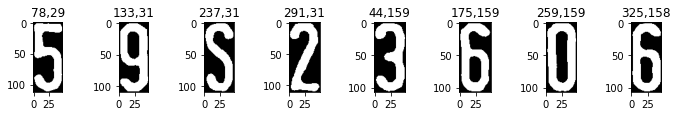

In [14]:
# Character_segment("E:\\Plate_data\\Cropped_train\\anh3.jpg", "C:\\Users\\ASUS\\Documents")
# E:\Sem5\Raw\Plate_data\Cropped_train
Character_segment("E:\Sem5\Raw\Plate_data\Cropped_train\\anh1085.jpg", 'C:\\Users\\mr Hai\\OneDrive\\Desktop' )